Detect objects in images, expand bounding boxes with padding or a scale factor, crop to specific aspect ratios, and keep detection data aligned after transforms.

## Problem

Object detection gives you tight bounding boxes, but downstream tasks need more flexibility:

| Task | Challenge |
|------|-----------|
| Product thumbnails | Bounding boxes clip the subject; need padding for context |
| Social media repurposing | Source is 16:9, need 9:16 and 1:1 crops centred on the subject |
| Resize + re-detect | After resizing or cropping, bounding box coordinates no longer align |
| Video reframing | Need to spatially crop a video around a detected subject |

## Solution

This notebook addresses three feature requests:

| Ticket | Feature | Section |
|--------|---------|---------|
| [PXT-968](https://pixeltable.atlassian.net/browse/PXT-968) | Expand bounding boxes with padding / scale factor | [Expand bounding boxes with padding](#expand-bounding-boxes-with-padding) |
| [PXT-967](https://pixeltable.atlassian.net/browse/PXT-967) | Keep bbox coordinates aligned after resize or crop | [Keep bounding boxes aligned after transforms](#keep-bounding-boxes-aligned-after-transforms) |
| [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) | Aspect-ratio-aware video cropping around a subject | [Crop to a target aspect ratio](#crop-to-a-target-aspect-ratio), [Crop videos](#crop-videos-around-detected-subjects), [Track and follow](#track-and-follow-subjects-across-frames) |

**New built-in functions:**

- **`expand_bbox`** — Add pixel padding or a scale factor around a bounding box *(PXT-968)*
- **`fit_bbox_to_aspect`** — Compute an aspect-ratio-matching crop region centred on a subject *(PXT-966)*
- **`rescale_bbox`** — Keep bounding boxes aligned after `resize()` *(PXT-967)*
- **`offset_bbox`** — Keep bounding boxes aligned after `crop()` *(PXT-967)*
- **`video.crop()`** — Spatially crop a video, optionally resizing to a target resolution *(PXT-966)*
- **`smooth_reframe`** — Tracking crop that follows a moving subject across frames *(PXT-966)*

All of these are computed columns — they run automatically when you insert new data.

### Setup

In [1]:
# Use local pixeltable from this branch so the new UDFs are available.
# Remove these lines once the UDFs ship in a released version.
# IMPORTANT: this cell must run BEFORE any `import pixeltable` —
# if you hit an ImportError, restart the kernel and re-run all cells.
import sys
from pathlib import Path

_repo_root = str(Path.cwd().parents[4])  # docs/release/howto/cookbooks/images → repo root
if _repo_root not in sys.path:
    sys.path.insert(0, _repo_root)

%pip install -qU pixeltable-yolox


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pixeltable as pxt
from pixeltable.functions.yolox import yolox
from pixeltable.functions.image import (
    expand_bbox,
    fit_bbox_to_aspect,
    offset_bbox,
    rescale_bbox,
)
from pixeltable.functions.vision import draw_bounding_boxes

### Load images

In [3]:
pxt.drop_dir('crop_demo', force=True)
pxt.create_dir('crop_demo')

/Users/pierre/pixeltable/pixeltable/env.py:492: UserWarning: Progress reporting is disabled because ipywidgets is not installed. To fix this, run: `pip install ipywidgets`
  warnings.warn(


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'crop_demo'.


In [4]:
images = pxt.create_table('crop_demo/images', {'image': pxt.Image})

Created table 'images'.


In [5]:
image_urls = [
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg',
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000090.jpg',
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000106.jpg',
]

images.insert([{'image': url} for url in image_urls])

Inserted 3 rows with 0 errors in 0.34 s (8.84 rows/s)


3 rows inserted.

### Detect objects

Run YOLOX to get bounding boxes and class labels. Then extract the best (highest-confidence) detection per image.

In [6]:
images.add_computed_column(
    detections=yolox(images.image, model_id='yolox_m', threshold=0.5)
)

Added 3 column values with 0 errors in 1.68 s (1.79 rows/s)


3 rows updated.

In [ ]:
@pxt.udf
def best_bbox(detections: dict) -> tuple[int, int, int, int] | None:
    """Return the bounding box of the highest-confidence detection."""
    scores = detections.get('scores', [])
    bboxes = detections.get('bboxes', [])
    if not scores:
        return None
    idx = scores.index(max(scores))
    b = bboxes[idx]
    return (round(b[0]), round(b[1]), round(b[2]), round(b[3]))


@pxt.udf
def bbox_to_list(bbox: tuple[int, int, int, int]) -> list[list[int]]:
    """Wrap a single bbox into the list-of-lists format for draw_bounding_boxes."""
    return [list(bbox)]


images.add_computed_column(bbox=best_bbox(images.detections))

Added 3 column values with 0 errors in 0.02 s (191.64 rows/s)


3 rows updated.

draw_bounding_boxes,bbox
,"[2, 56, 463, 486]"
,"[235, 353, 308, 415]"
,"[46, 94, 490, 363]"

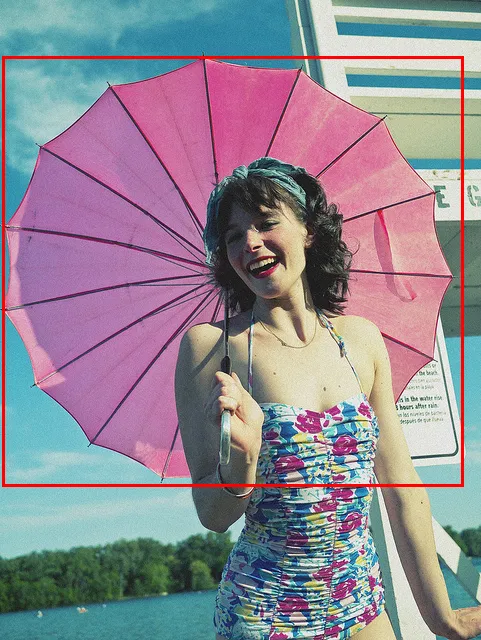
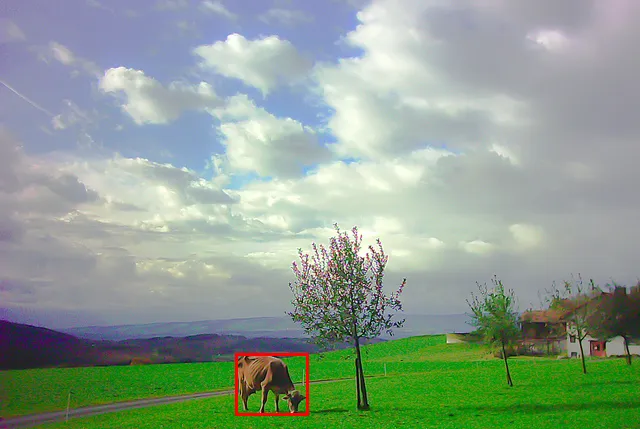
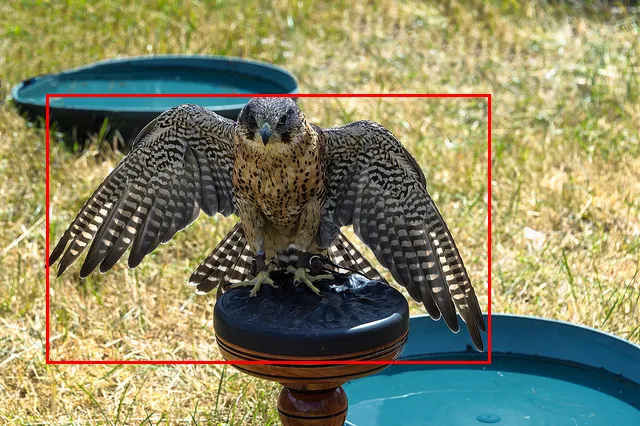

In [ ]:
# Show detected bounding boxes drawn on the images using the built-in vision UDF
images.select(
    draw_bounding_boxes(images.image, bbox_to_list(images.bbox), color='red', width=3),
    images.bbox,
).collect()

## Expand bounding boxes with padding
*Addresses [PXT-968](https://pixeltable.atlassian.net/browse/PXT-968) — Variata needs to crop images around a detected bounding box with additional context/buffer around the subject.*

Detection boxes are often tight to the subject. `expand_bbox` lets you add breathing room before cropping — either as a **scale factor** (e.g. 1.4 = 40% bigger) or **pixel padding** (e.g. 30px on every side). Both can be combined: scale first, then pad.

In [9]:
# Expand the bounding box by 40% around the centre
images.add_computed_column(
    bbox_expanded=expand_bbox(
        images.bbox, images.image.width, images.image.height,
        margin_factor=1.4,
    )
)

# Crop: tight (original bbox) vs. expanded
images.add_computed_column(crop_tight=images.image.crop(images.bbox))
images.add_computed_column(crop_expanded=images.image.crop(images.bbox_expanded))

Added 3 column values with 0 errors in 0.02 s (140.66 rows/s)
Added 3 column values with 0 errors in 0.02 s (121.99 rows/s)


Added 3 column values with 0 errors in 0.02 s (127.88 rows/s)


3 rows updated.

crop_tight,crop_expanded
,
,
,

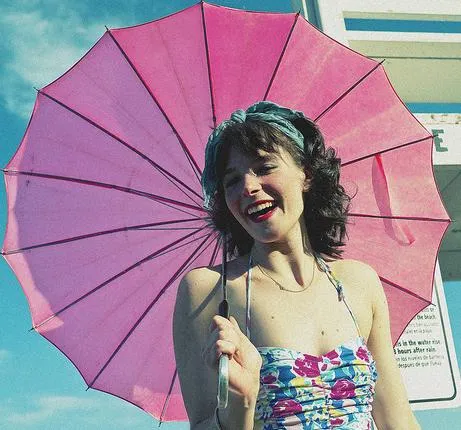
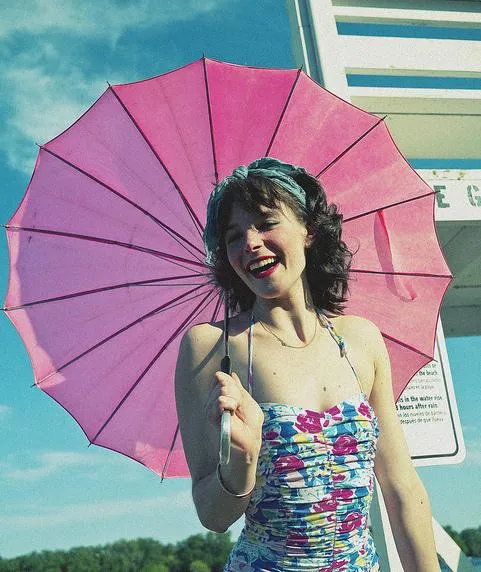
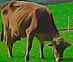
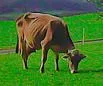
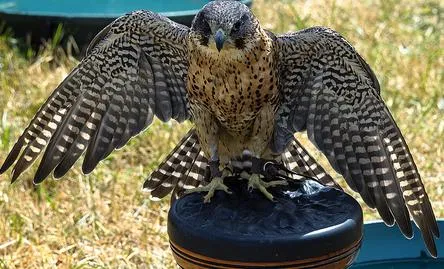
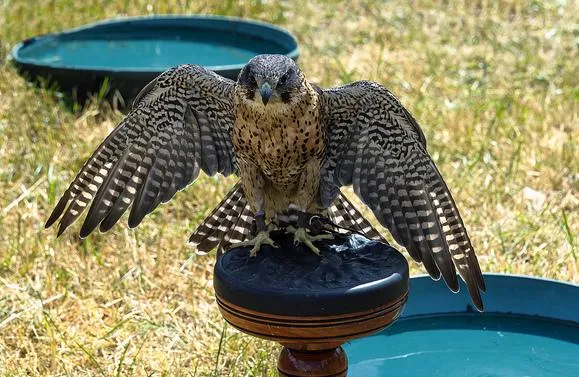

In [10]:
# Compare tight crop vs expanded crop side by side
images.select(images.crop_tight, images.crop_expanded).collect()

You can also use pixel padding instead of (or in addition to) a scale factor:

Added 3 column values with 0 errors in 0.02 s (148.48 rows/s)
Added 3 column values with 0 errors in 0.02 s (138.06 rows/s)


crop_tight,crop_padded
,
,
,

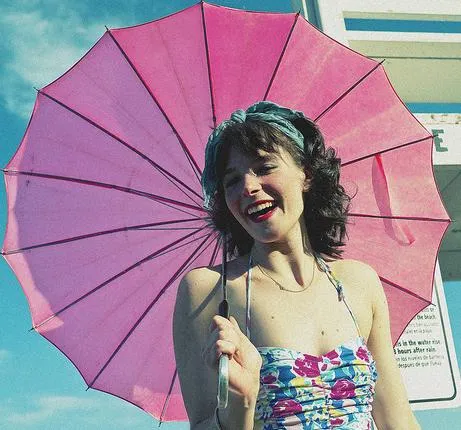
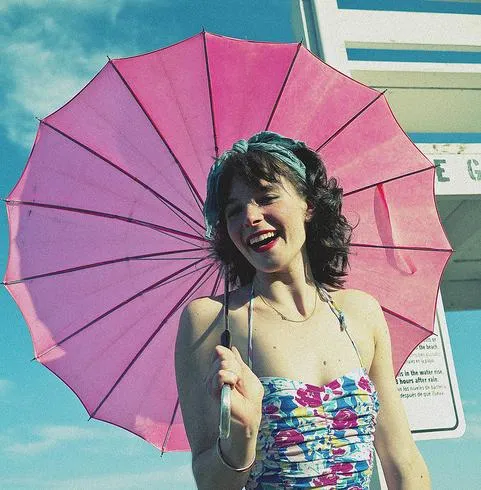
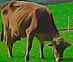
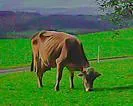
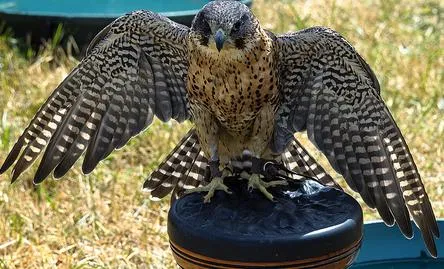
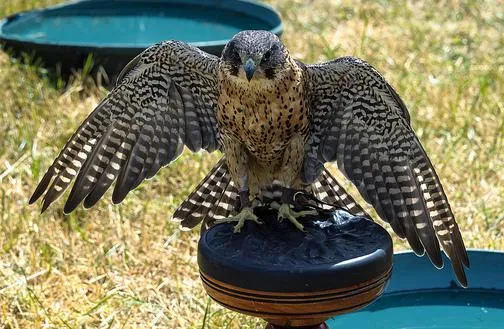

In [11]:
# Add 30 pixels on every side
images.add_computed_column(
    bbox_padded=expand_bbox(
        images.bbox, images.image.width, images.image.height,
        padding=30,
    )
)
images.add_computed_column(crop_padded=images.image.crop(images.bbox_padded))

images.select(images.crop_tight, images.crop_padded).collect()

## Crop to a target aspect ratio
*Addresses [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) — Dicer needs aspect-ratio-aware crop calculation that keeps the detected subject in frame.*

`fit_bbox_to_aspect` computes a crop region that **contains the subject** and **matches a target aspect ratio**. The region is centred on the bounding box and clamped to image bounds — no distortion, no stretching.

This is the key building block for social-media repurposing: generate 9:16, 1:1, and 4:5 crops from a single source image. As Dicer's dev noted: *"We usually do aspect ratio inputs rather than target resolution since the resolution may differ based on input media."*

In [12]:
# Compute crop regions for three different aspect ratios
images.add_computed_column(
    box_9x16=fit_bbox_to_aspect(
        images.bbox, images.image.width, images.image.height,
        aspect_ratio='9:16',
    )
)
images.add_computed_column(
    box_1x1=fit_bbox_to_aspect(
        images.bbox, images.image.width, images.image.height,
        aspect_ratio='1:1',
    )
)
images.add_computed_column(
    box_4x5=fit_bbox_to_aspect(
        images.bbox, images.image.width, images.image.height,
        aspect_ratio='4:5',
    )
)

# Apply the crops
images.add_computed_column(crop_9x16=images.image.crop(images.box_9x16))
images.add_computed_column(crop_1x1=images.image.crop(images.box_1x1))
images.add_computed_column(crop_4x5=images.image.crop(images.box_4x5))

Added 3 column values with 0 errors in 0.02 s (138.47 rows/s)
Added 3 column values with 0 errors in 0.02 s (129.97 rows/s)
Added 3 column values with 0 errors in 0.02 s (162.45 rows/s)
Added 3 column values with 0 errors in 0.02 s (145.70 rows/s)


Added 3 column values with 0 errors in 0.02 s (134.69 rows/s)
Added 3 column values with 0 errors in 0.02 s (129.10 rows/s)


3 rows updated.

crop_9x16,crop_1x1,crop_4x5
,,
,,
,,

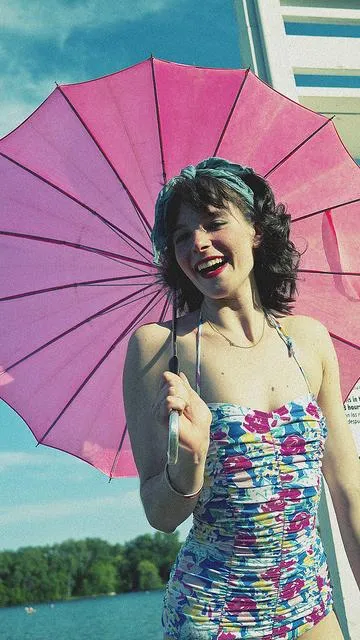
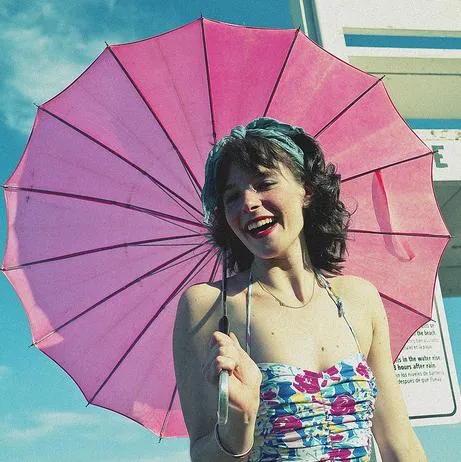
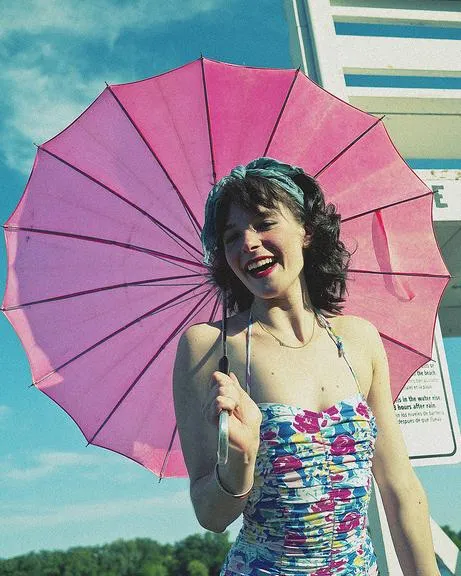
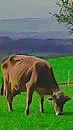
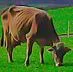
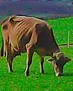
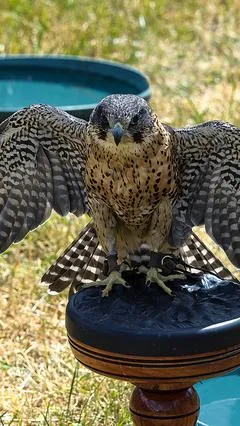
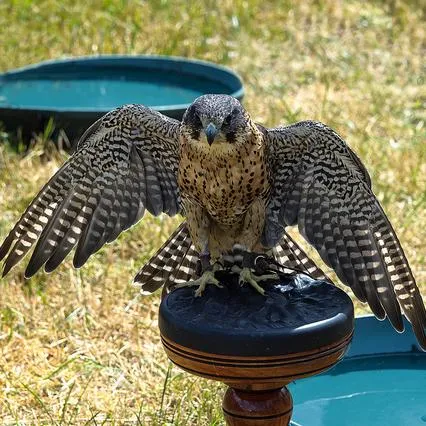
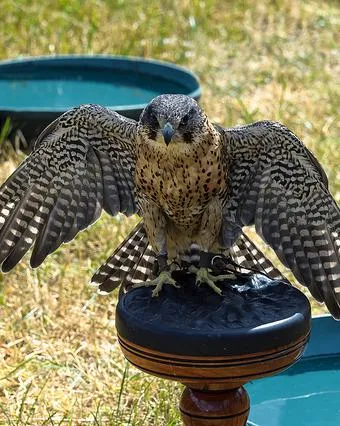

In [13]:
images.select(images.crop_9x16, images.crop_1x1, images.crop_4x5).collect()

## Keep bounding boxes aligned after transforms
*Addresses [PXT-967](https://pixeltable.atlassian.net/browse/PXT-967) — Variata runs object detection on images, then resizes or crops those images. After transformation, the original bounding box coordinates no longer align.*

When you resize or crop an image, the original bounding box coordinates no longer match the new pixel grid. Pixeltable provides two utilities to fix this:

- **`rescale_bbox`** — after `resize()`, scales coordinates proportionally
- **`offset_bbox`** — after `crop()`, offsets coordinates relative to the new image origin

### After resize

In [14]:
# Resize images to 320x240
images.add_computed_column(resized=images.image.resize((320, 240)))

# Rescale the bounding box to match the new dimensions
images.add_computed_column(
    bbox_resized=rescale_bbox(
        images.bbox,
        [images.image.width, images.image.height],
        (320, 240),
    )
)

# Crop the resized image using the rescaled bbox
images.add_computed_column(
    crop_from_resized=images.resized.crop(images.bbox_resized)
)

Added 3 column values with 0 errors in 0.02 s (121.85 rows/s)


Added 3 column values with 0 errors in 0.02 s (144.09 rows/s)
Added 3 column values with 0 errors in 0.02 s (170.97 rows/s)


3 rows updated.

resized,bbox_resized,crop_from_resized
,"[118, 197, 154, 232]",
,"[1, 21, 308, 182]",
,"[23, 53, 245, 205]",

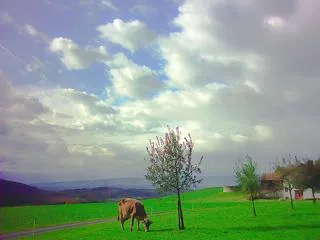
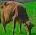
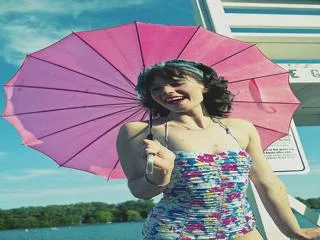
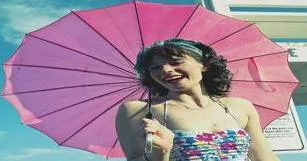
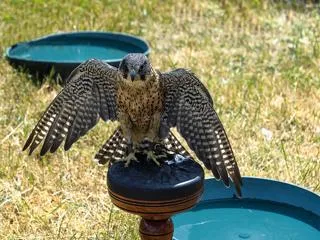
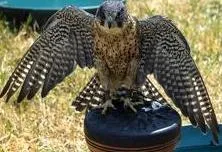

In [15]:
images.select(images.resized, images.bbox_resized, images.crop_from_resized).collect()

### After crop

In [16]:
# After cropping to 1:1, translate the original bbox into the cropped image's coordinate space
images.add_computed_column(
    bbox_in_crop=offset_bbox(images.bbox, images.box_1x1)
)

Added 3 column values with 0 errors in 0.01 s (221.58 rows/s)


3 rows updated.

crop_1x1,bbox_in_crop
,"[0, 5, 73, 67]"
,"[0, 16, 461, 446]"
,"[0, 94, 426, 363]"

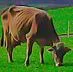
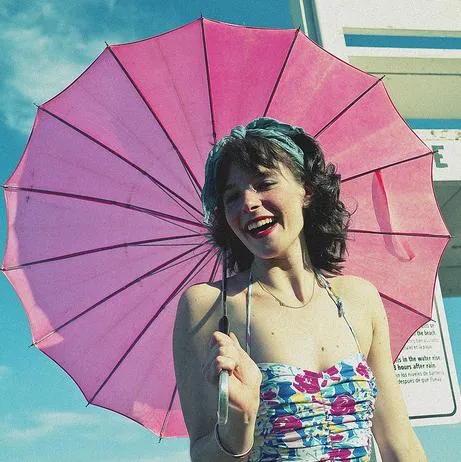
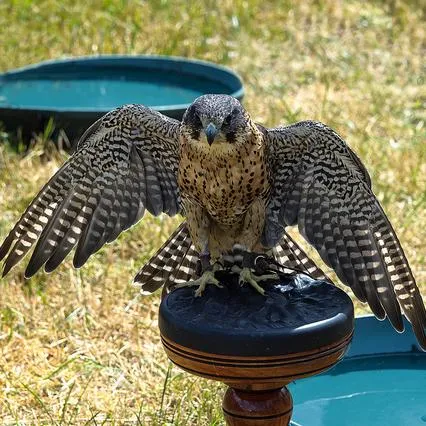

In [17]:
images.select(images.crop_1x1, images.bbox_in_crop).collect()

## Crop videos around detected subjects
*Addresses [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) — Dicer needs to generate cropped videos at various aspect ratios (e.g. 16:9 → 9:16) while keeping a detected subject in frame.*

The same workflow extends to videos: detect on a representative frame, compute the crop region with `fit_bbox_to_aspect`, then apply `video.crop()` which uses ffmpeg under the hood. The optional `target_size` parameter resizes the cropped region to an exact resolution without distortion.

> **Requires:** `ffmpeg` installed and in PATH

In [18]:
videos = pxt.create_table('crop_demo/videos', {'video': pxt.Video})

Created table 'videos'.


In [19]:
# Extract first frame for detection
videos.add_computed_column(
    first_frame=videos.video.extract_frame(timestamp=0.0)
)

# Run detection on the frame
videos.add_computed_column(
    detections=yolox(videos.first_frame, model_id='yolox_m', threshold=0.5)
)

# Get the best bounding box
videos.add_computed_column(bbox=best_bbox(videos.detections))

# Compute a 9:16 crop region centred on the subject
videos.add_computed_column(
    crop_box=fit_bbox_to_aspect(
        videos.bbox, videos.first_frame.width, videos.first_frame.height,
        aspect_ratio='9:16',
    )
)

# Crop the video and resize to 1080x1920
videos.add_computed_column(
    cropped_video=videos.video.crop(videos.crop_box, target_size=(1080, 1920))
)

Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.00 s


No rows affected.

In [20]:
# Use the Pursuit of Happiness clip from docs/resources/
video_path = str(Path(_repo_root) / 'docs' / 'resources' / 'The-Pursuit-of-Happiness-Video-Extract.mp4')

videos.insert(video=video_path)

Inserted 1 row with 0 errors in 1.91 s (0.52 rows/s)


1 row inserted.

draw_bounding_boxes,bbox,crop_box
,"[408, 93, 1271, 622]","[637, 0, 1042, 720]"

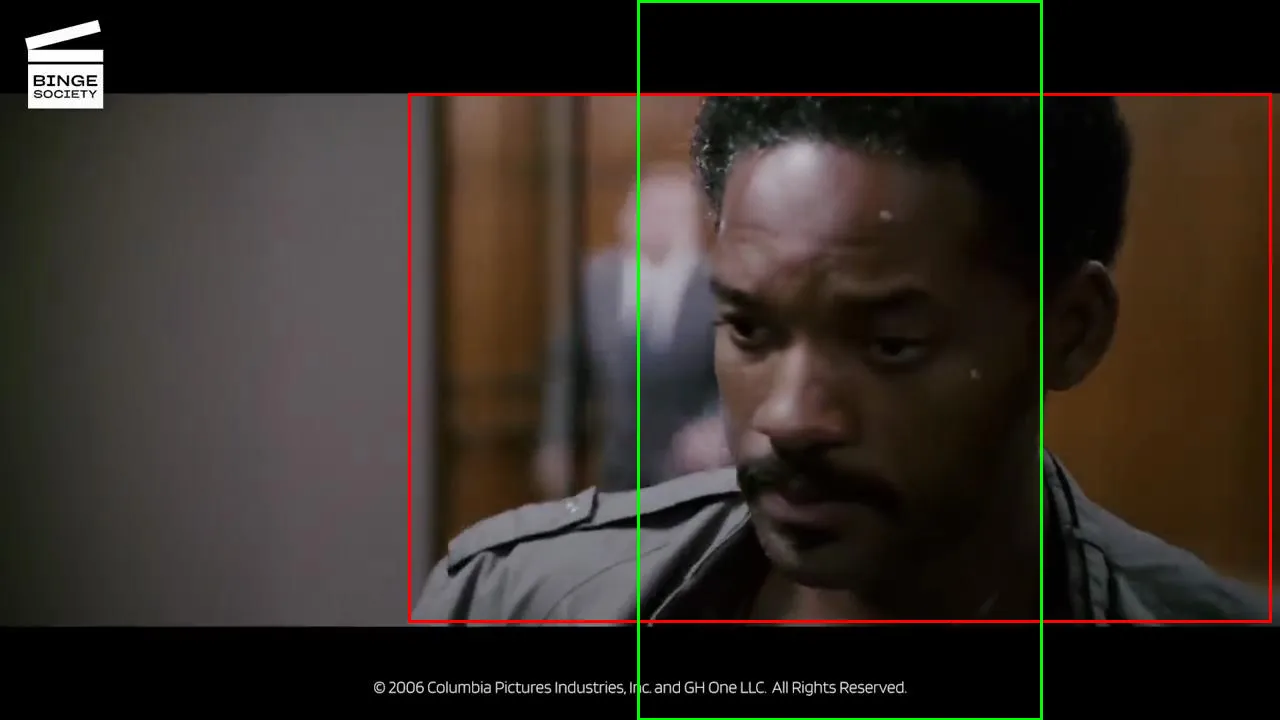

In [ ]:
# Show the detection bbox (red) and the 9:16 crop region (green) on the first frame
videos.select(
    draw_bounding_boxes(videos.first_frame, bbox_to_list(videos.bbox), color='red', width=3),
    draw_bounding_boxes(videos.first_frame, bbox_to_list(videos.crop_box), color='lime', width=3),
).collect()

crop,cropped_video
,

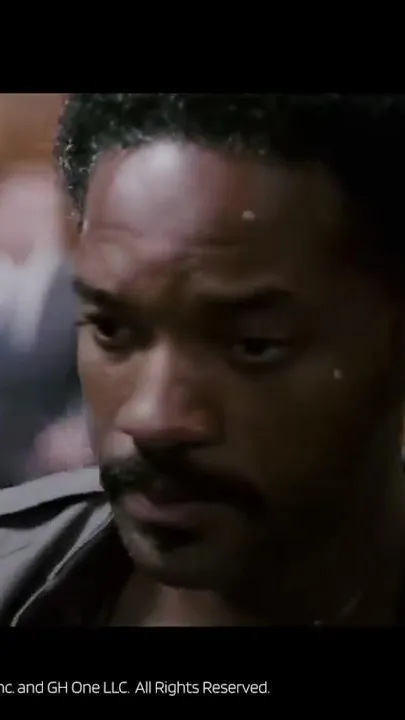
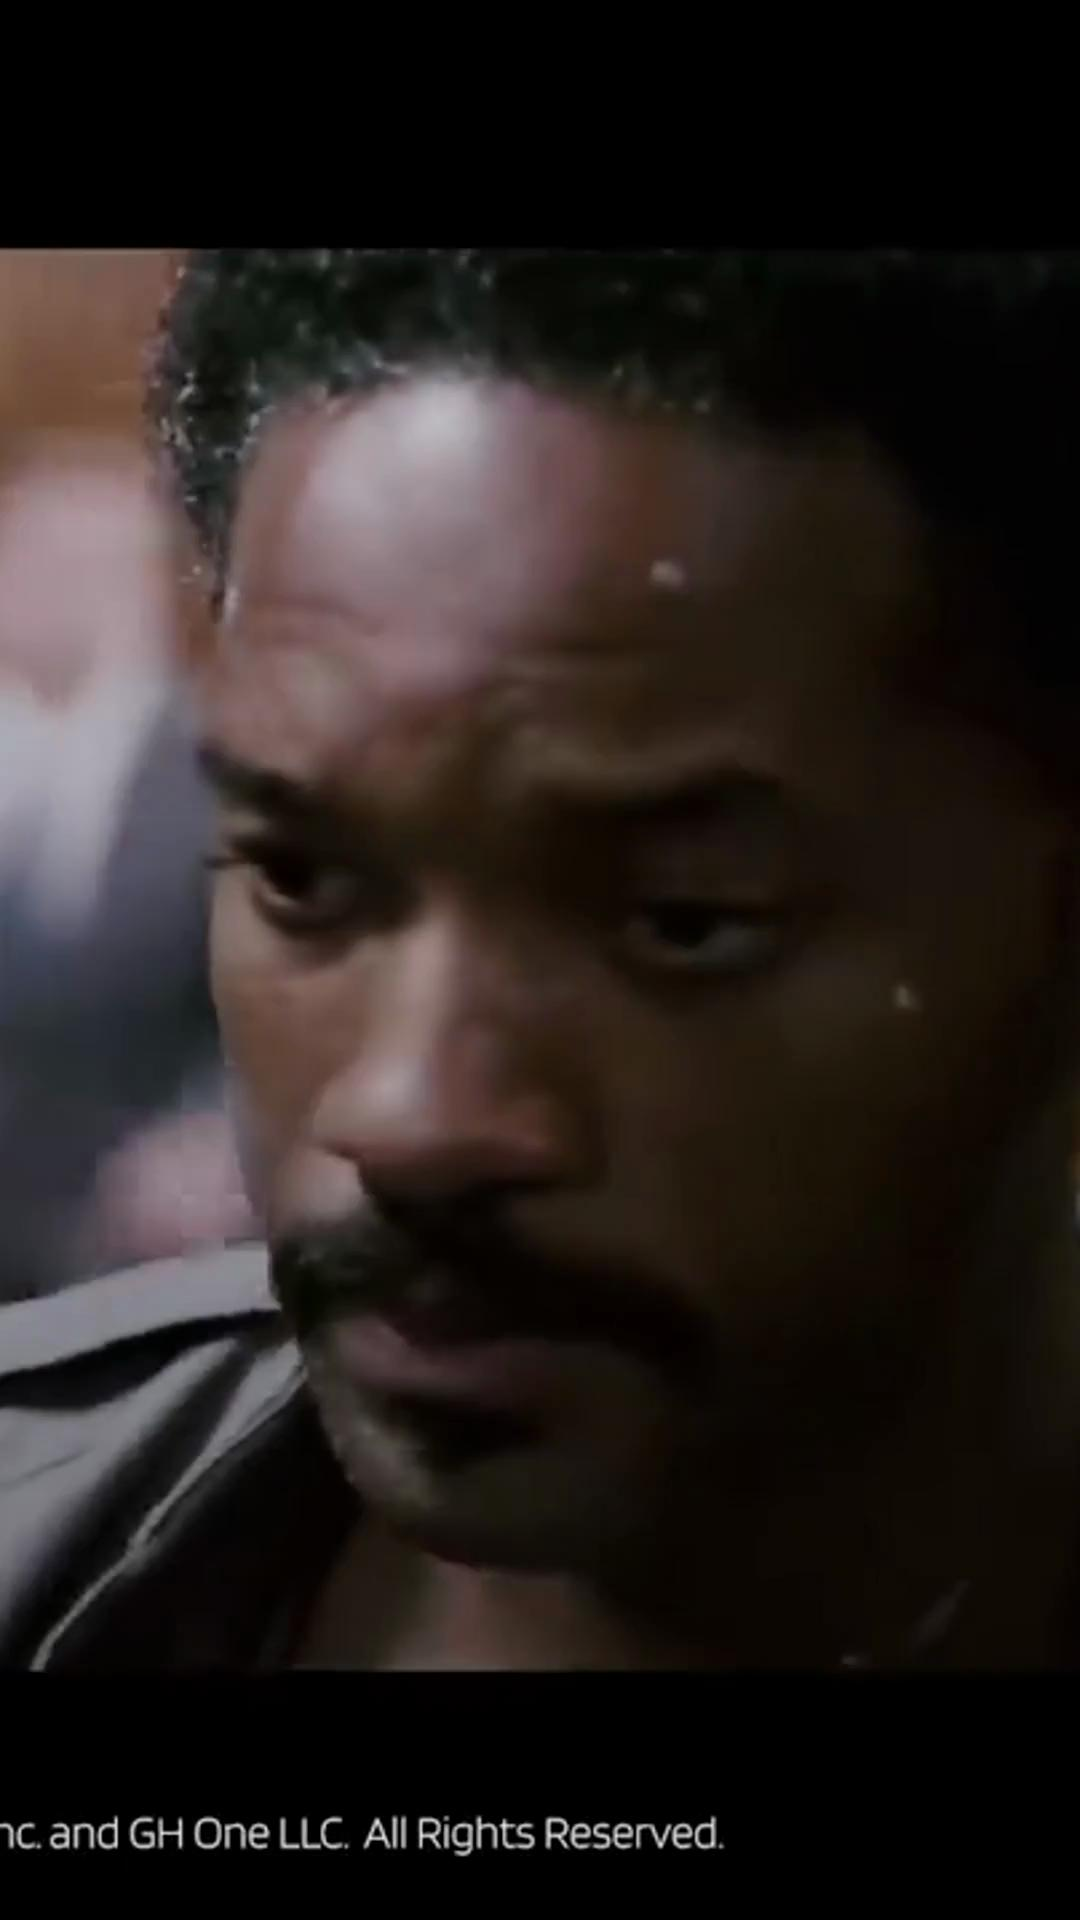

In [22]:
# Preview the cropped first frame to verify the 9:16 region
videos.select(
    videos.first_frame.crop(videos.crop_box),
    videos.cropped_video,
).collect()

## Track and follow subjects across frames
*Also addresses [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) — extends the static crop to handle moving subjects with smooth camera movement.*

The static `video.crop()` above applies a single crop box to every frame. For moving subjects you need a **tracking crop** that follows the object with smooth camera movement — no jarring jumps.

`smooth_reframe` is a UDA (aggregate function) that receives `(frame, bbox)` pairs in order and:

1. **Expands** each bounding box by a `margin_factor`
2. **Smooths** the centre position and zoom level with exponential moving averages
3. **Clamps** zoom rate so there are no abrupt in/out jumps
4. **Crops and resizes** each frame to the target resolution
5. **Assembles** the result into a new video

In [23]:
from pixeltable.functions.video import frame_iterator, smooth_reframe

# Create a table for tracking demos
tracking = pxt.create_table('crop_demo/tracking', {'video': pxt.Video})

# Create a frame view — extract frames at 15 fps for smoother tracking
frames = pxt.create_view(
    'crop_demo/tracking_frames', tracking,
    iterator=frame_iterator(tracking.video, fps=15),
)

# Run YOLOX on every frame
frames.add_computed_column(
    detections=yolox(frames.frame, model_id='yolox_m', threshold=0.5)
)
frames.add_computed_column(bbox=best_bbox(frames.detections))

Created table 'tracking'.
Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [ ]:
# Insert the full Pursuit of Happiness video (not the short extract)
# — the longer clip gives smooth_reframe enough frames to show the tracking effect.
full_video_path = str(Path(_repo_root) / 'docs' / 'resources' / 'The-Pursuit-of-Happiness.mp4')

tracking.insert(video=full_video_path)

draw_bbox,bbox
,"[386, 136, 1045, 623]"
,"[385, 146, 1030, 622]"
,"[390, 155, 1019, 624]"
,"[408, 164, 1013, 624]"
,"[409, 153, 1002, 625]"
,"[1023, 286, 1279, 624]"
,"[376, 126, 1050, 623]"
,"[405, 109, 1067, 625]"

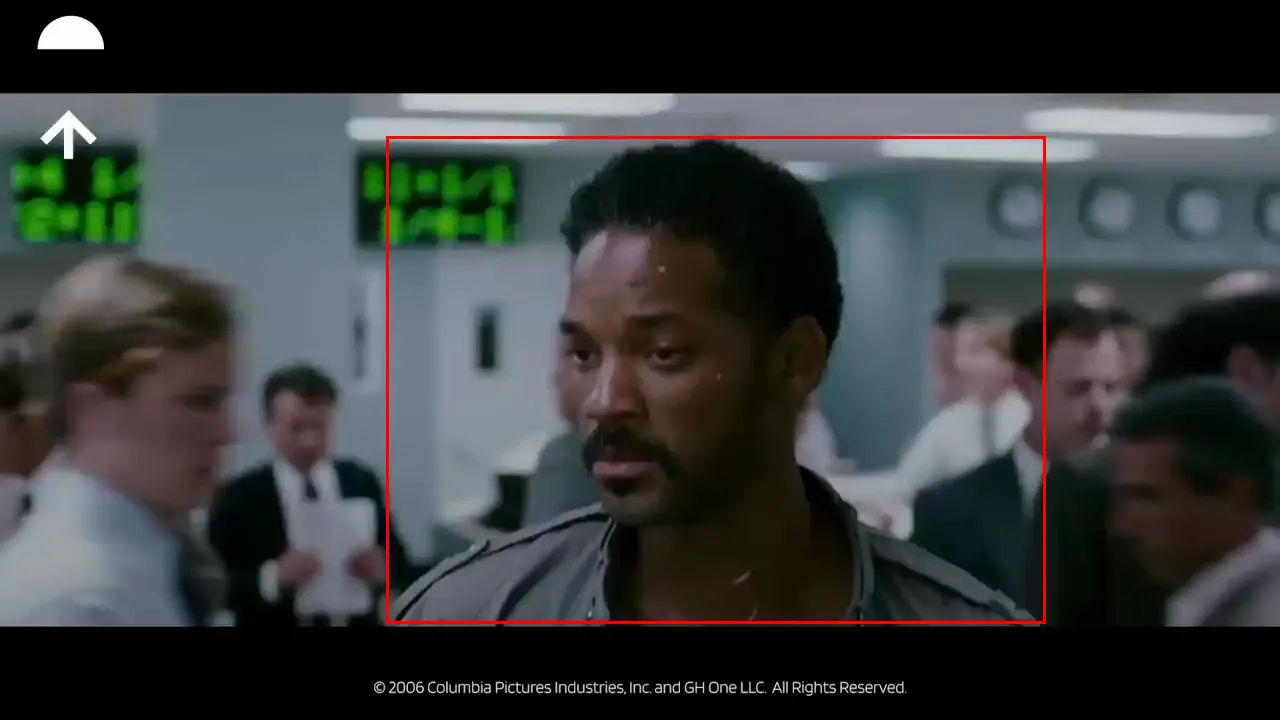
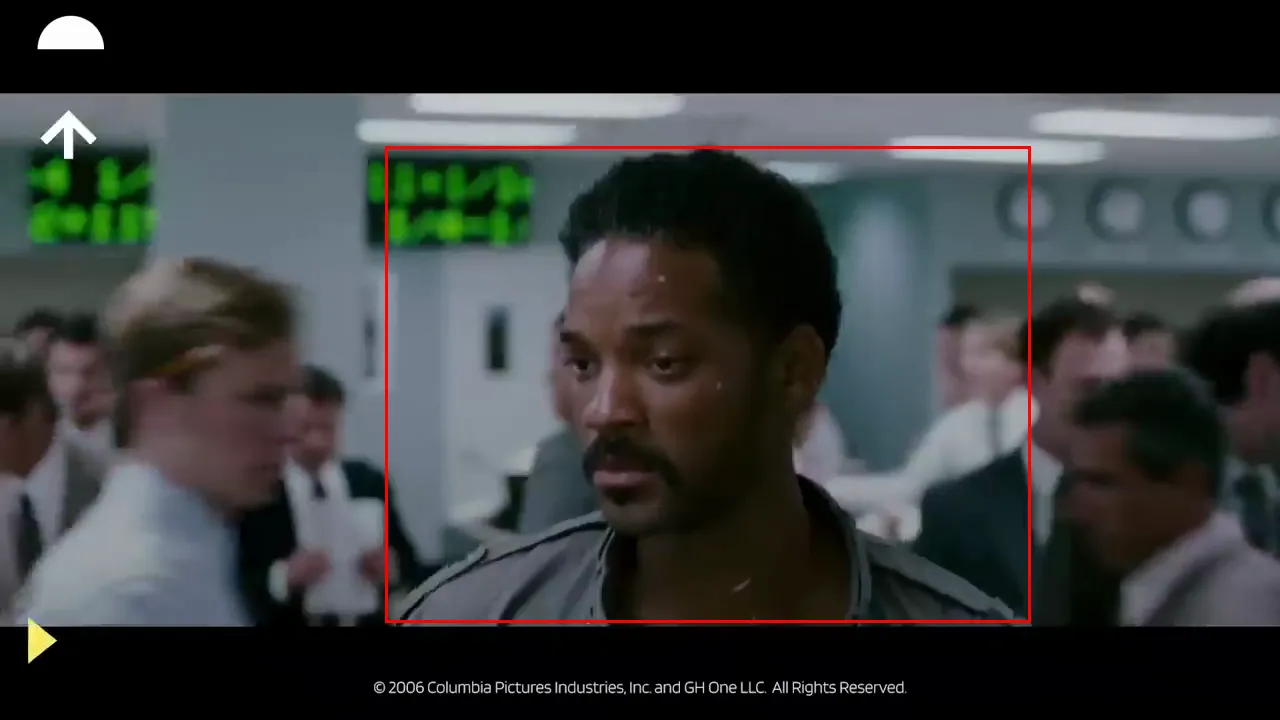
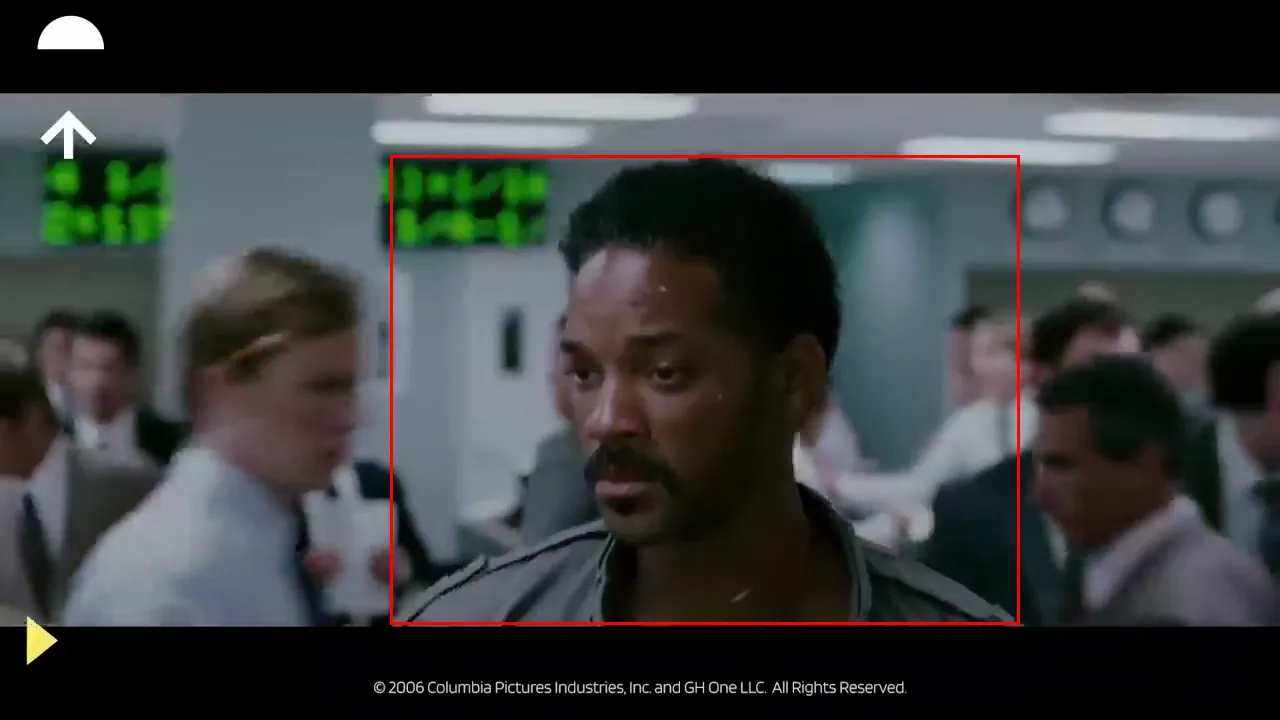
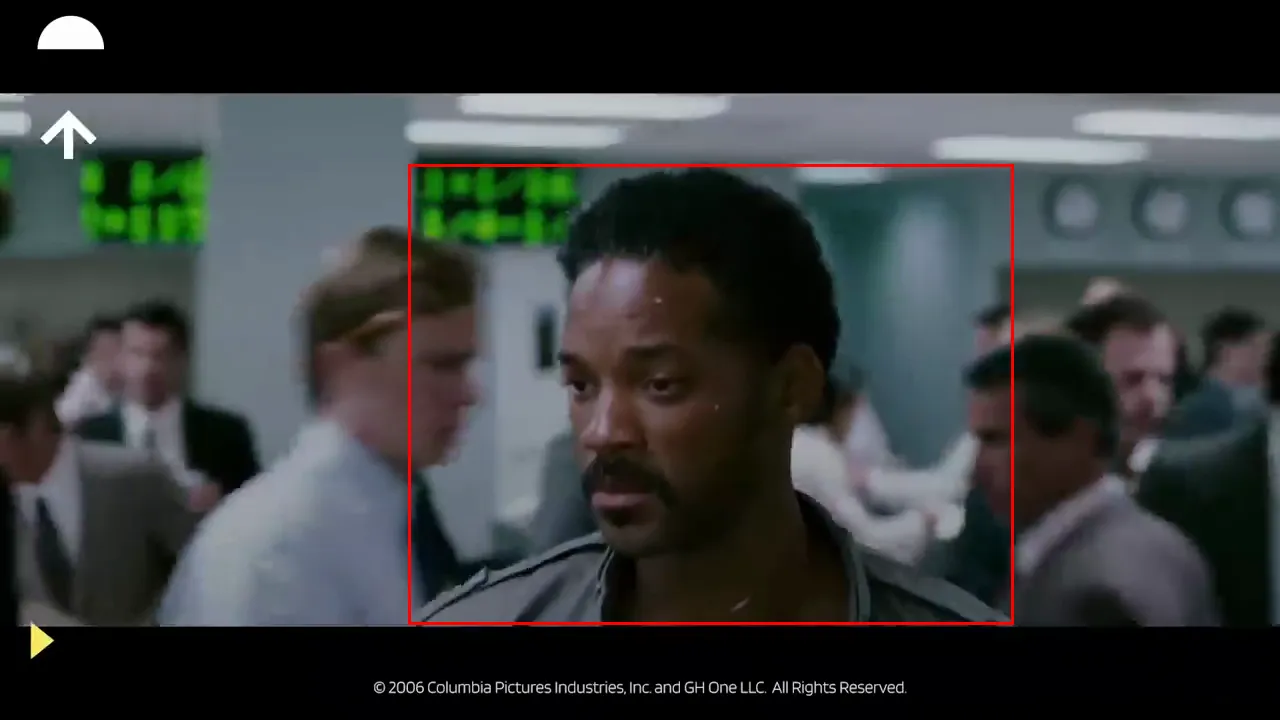
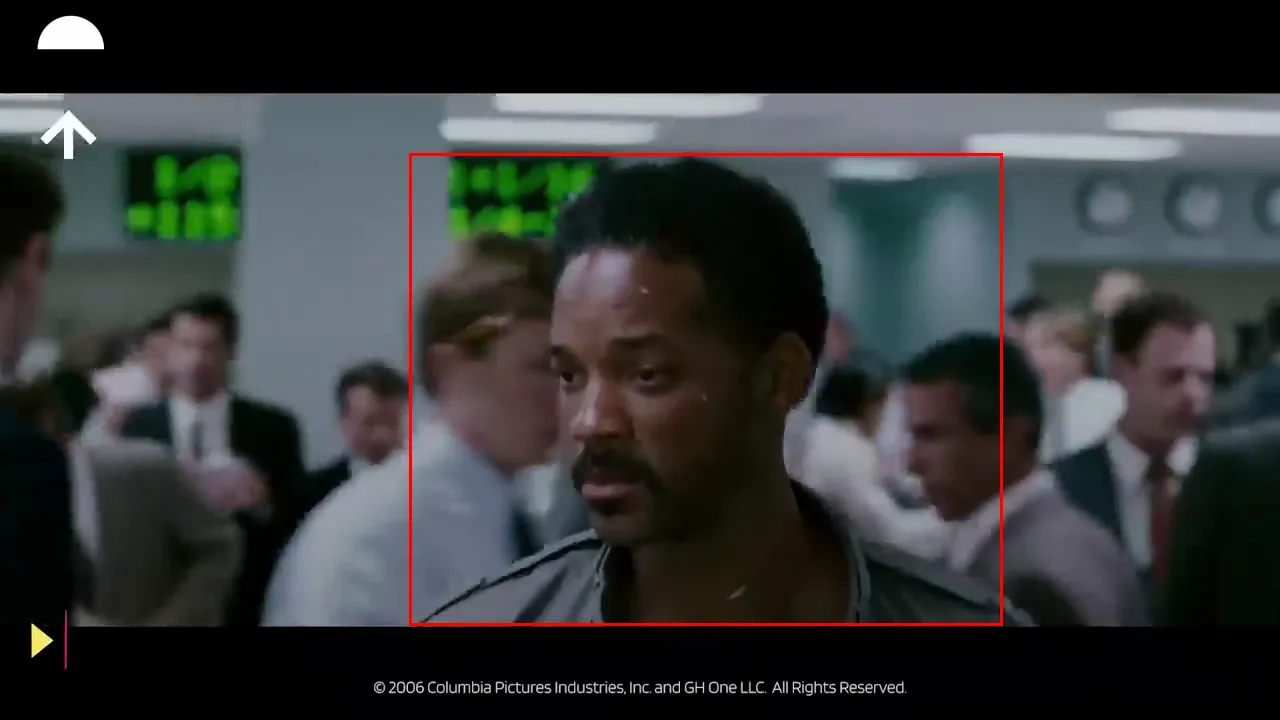
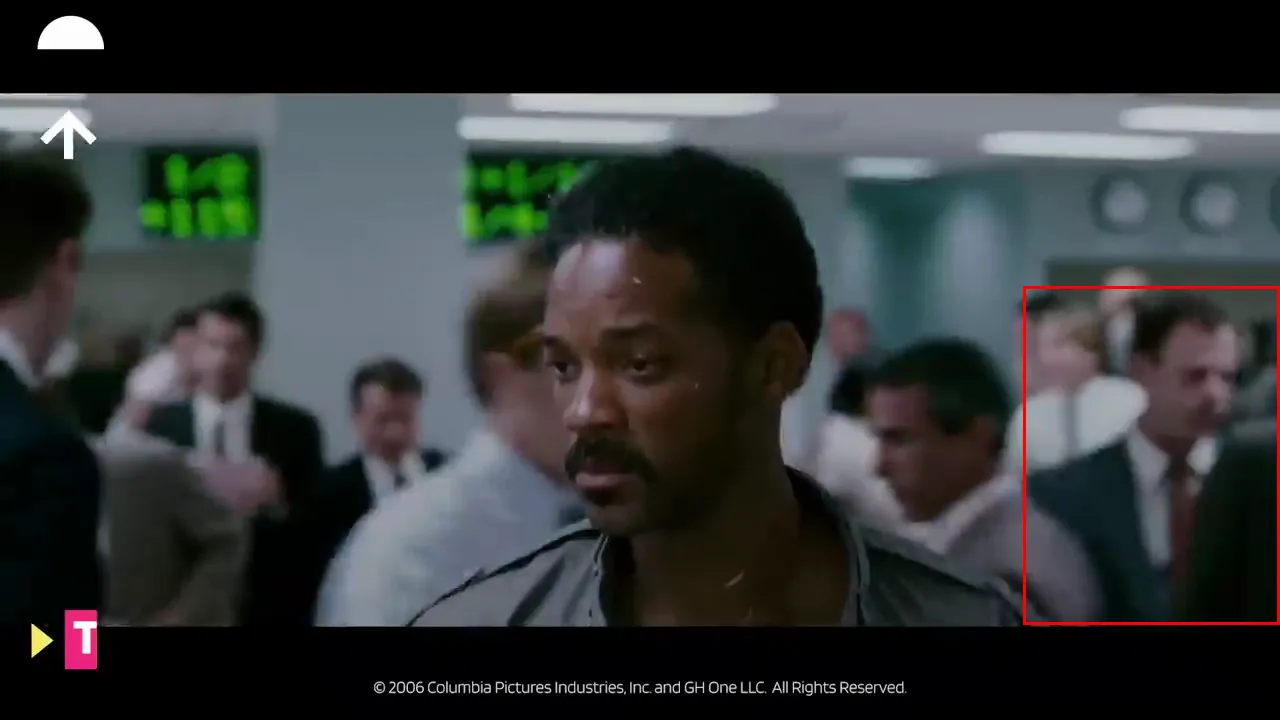
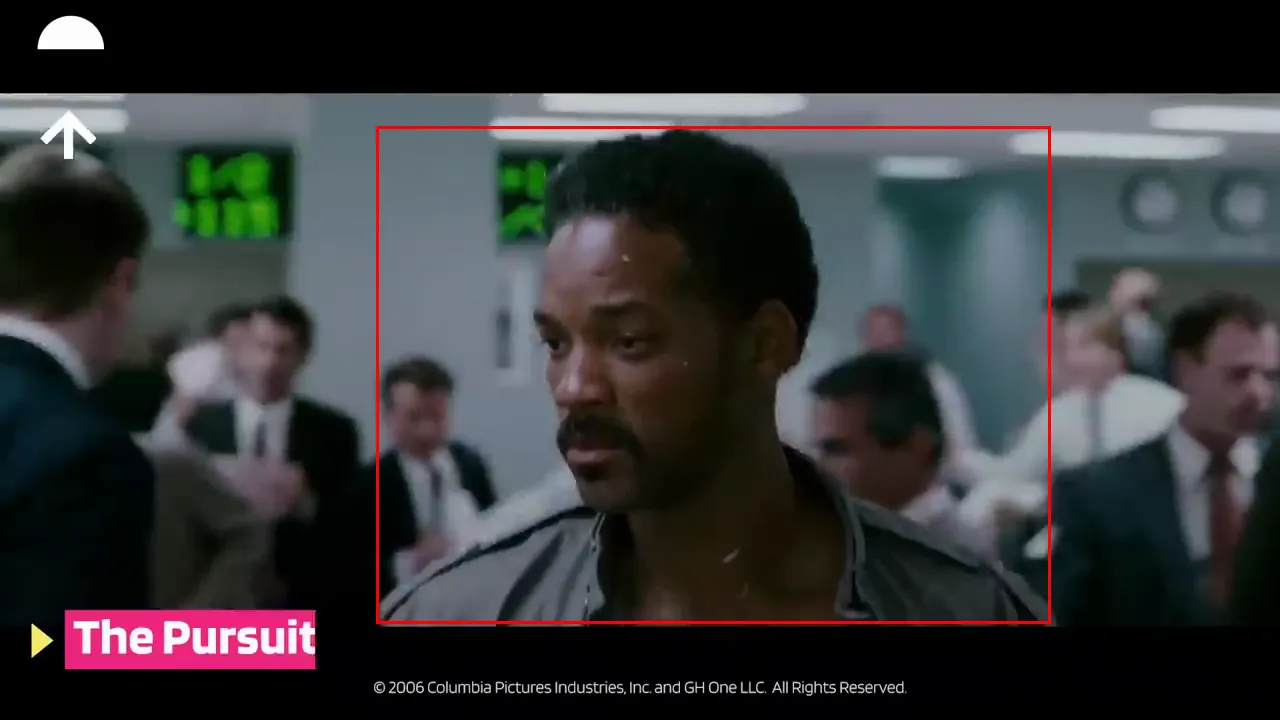
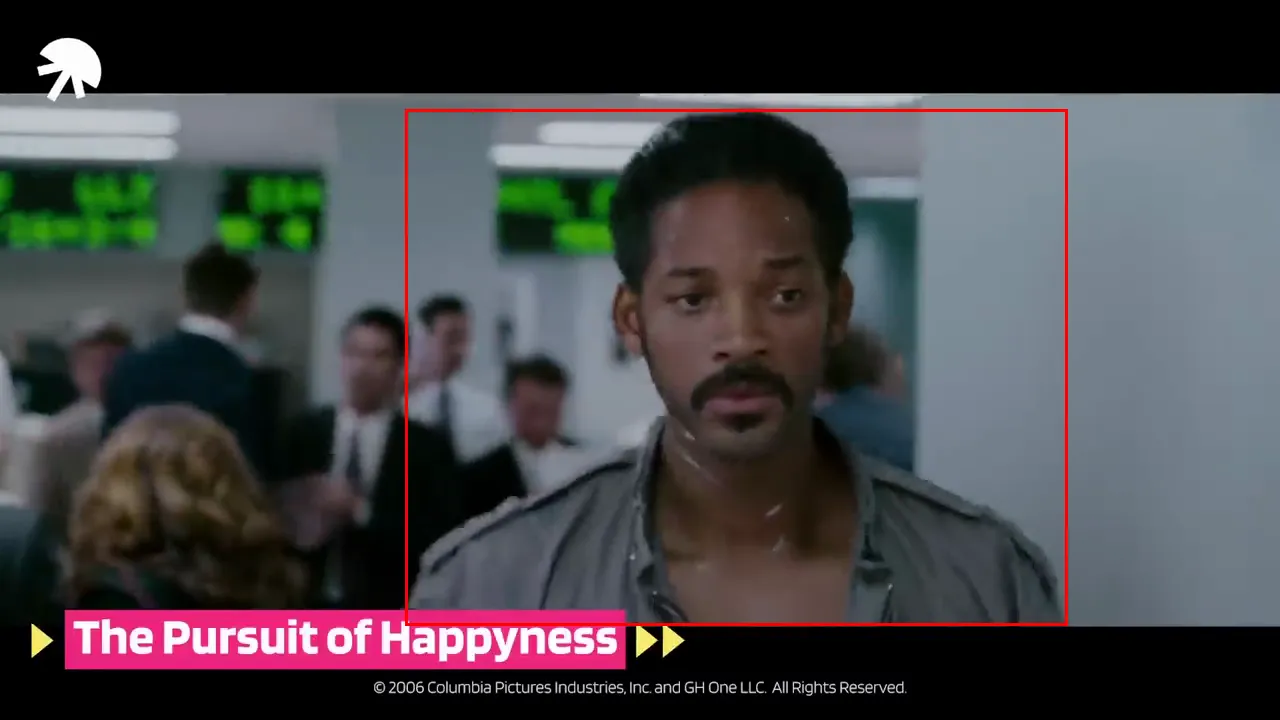

In [ ]:
# Preview a few frames with detected bboxes to see what smooth_reframe is tracking
frames.select(
    draw_bounding_boxes(frames.frame, bbox_to_list(frames.bbox), color='red', width=2),
    frames.bbox,
).limit(8).collect()

draw_bbox,bbox
,"[386, 136, 1045, 623]"
,"[385, 146, 1030, 622]"
,"[390, 155, 1019, 624]"
,"[408, 164, 1013, 624]"
,"[409, 153, 1002, 625]"
,"[1023, 286, 1279, 624]"
,"[376, 126, 1050, 623]"
,"[405, 109, 1067, 625]"

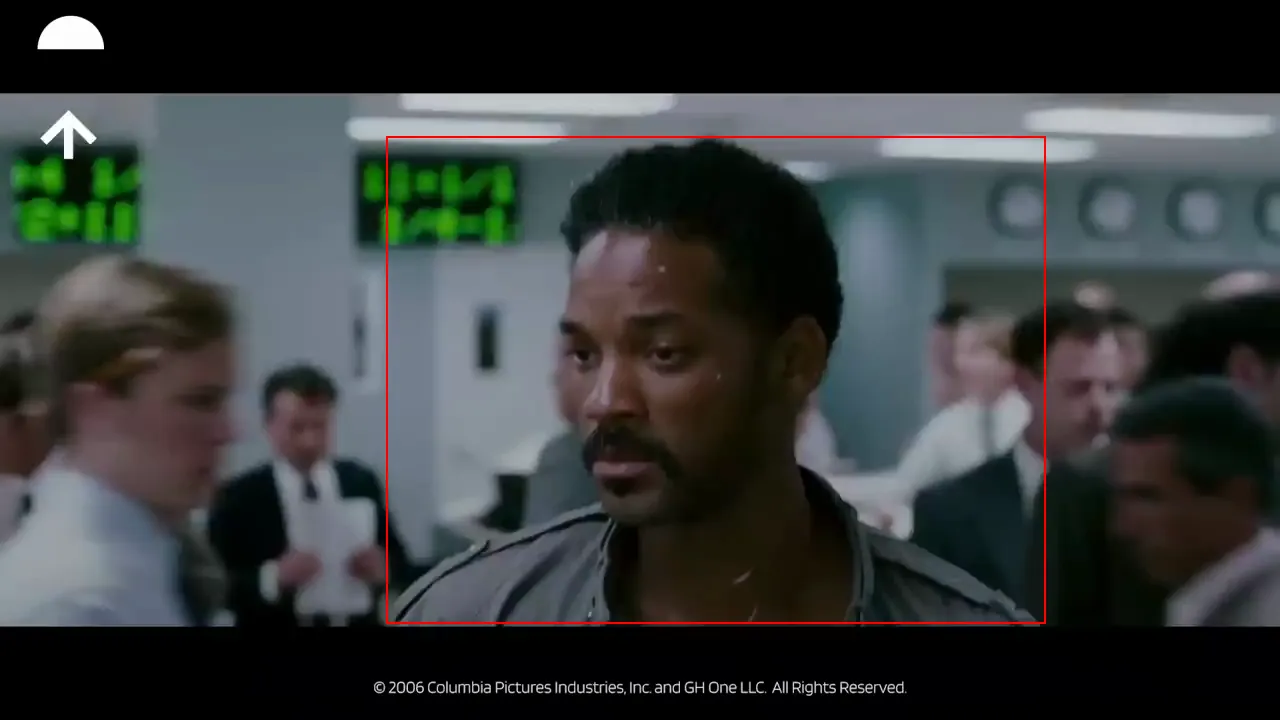
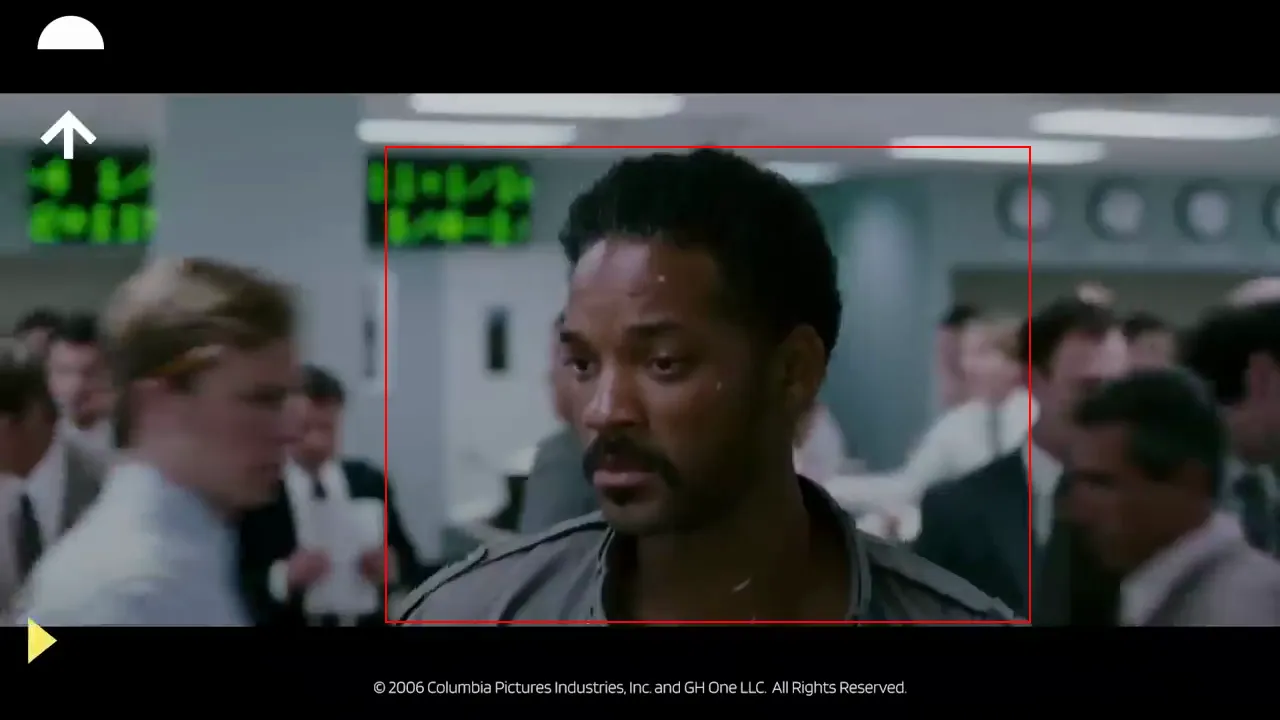
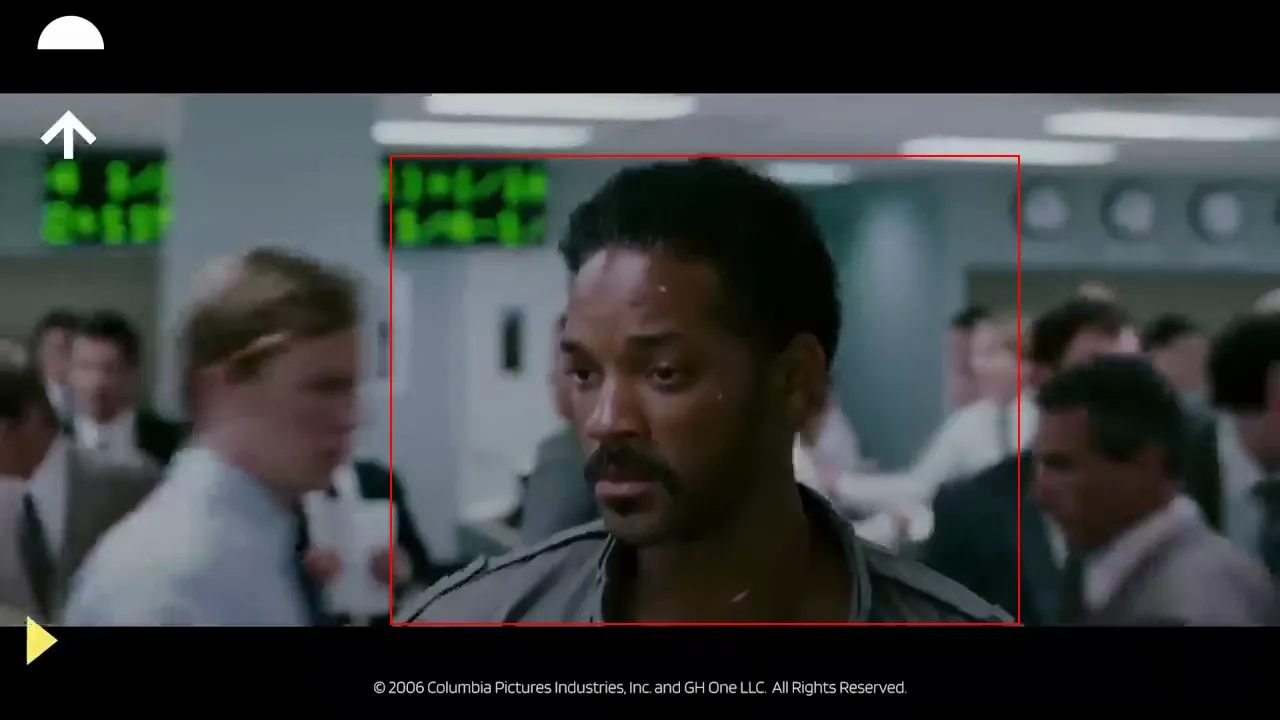
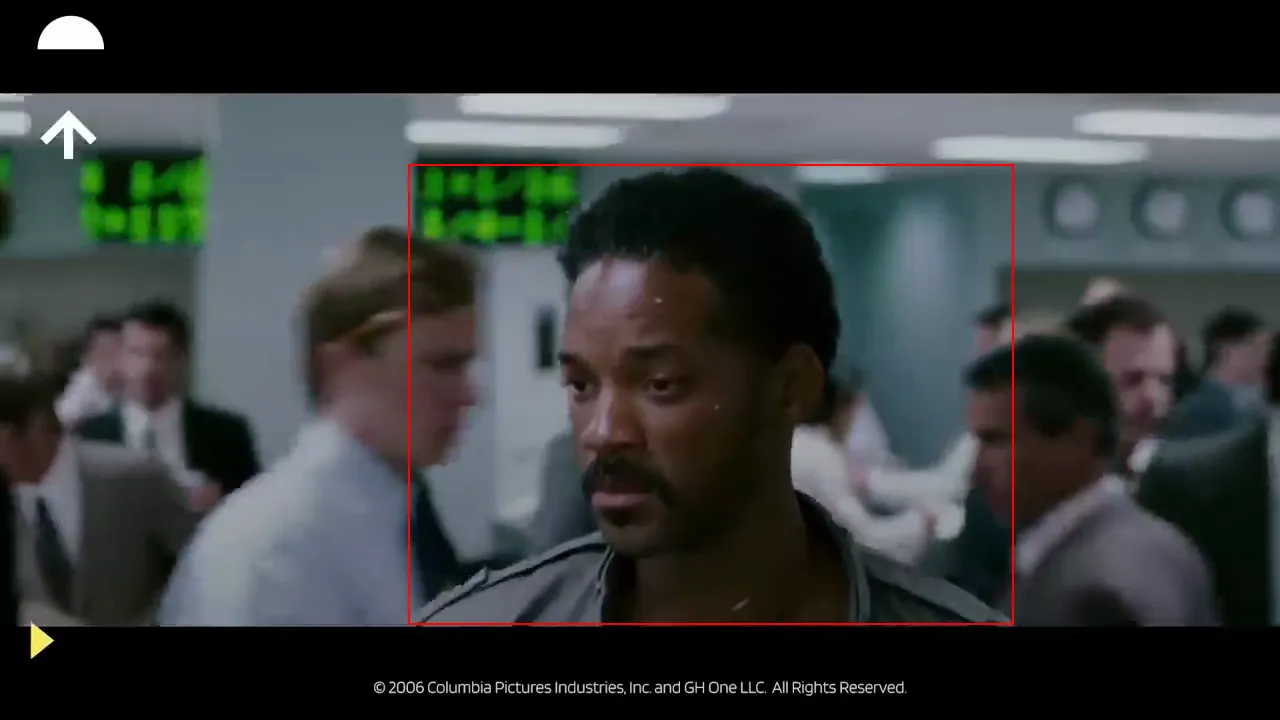
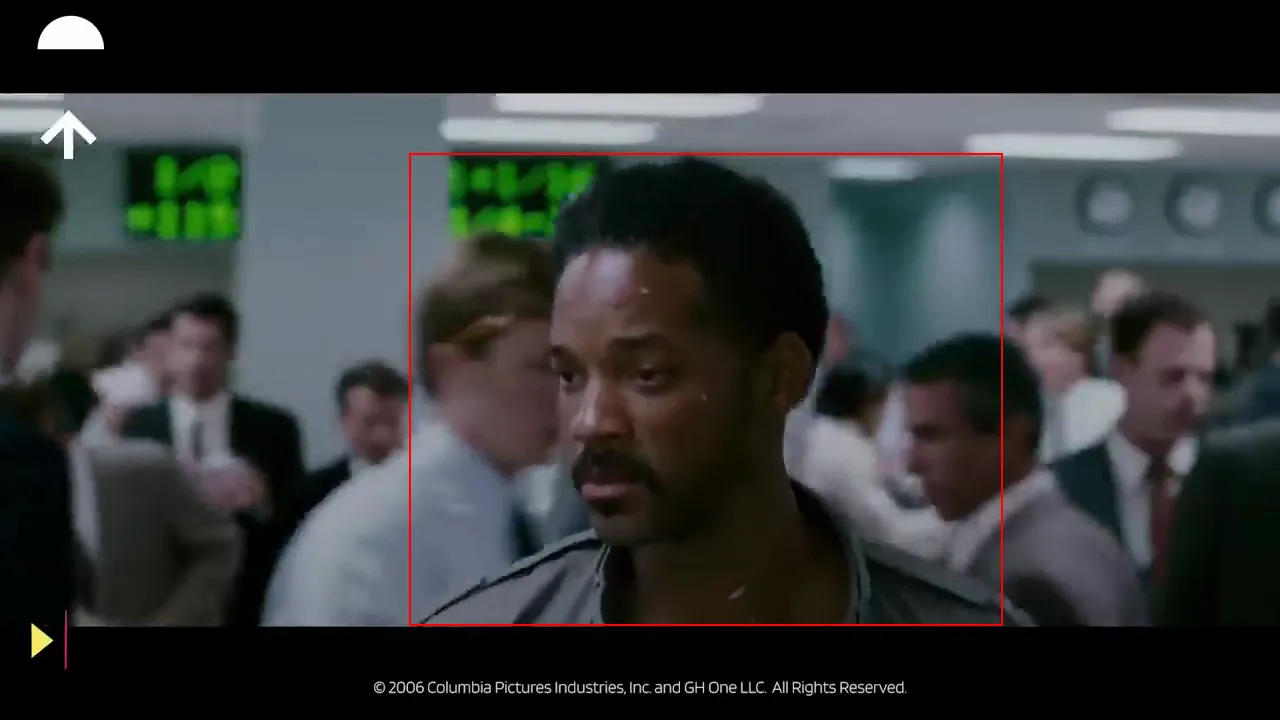
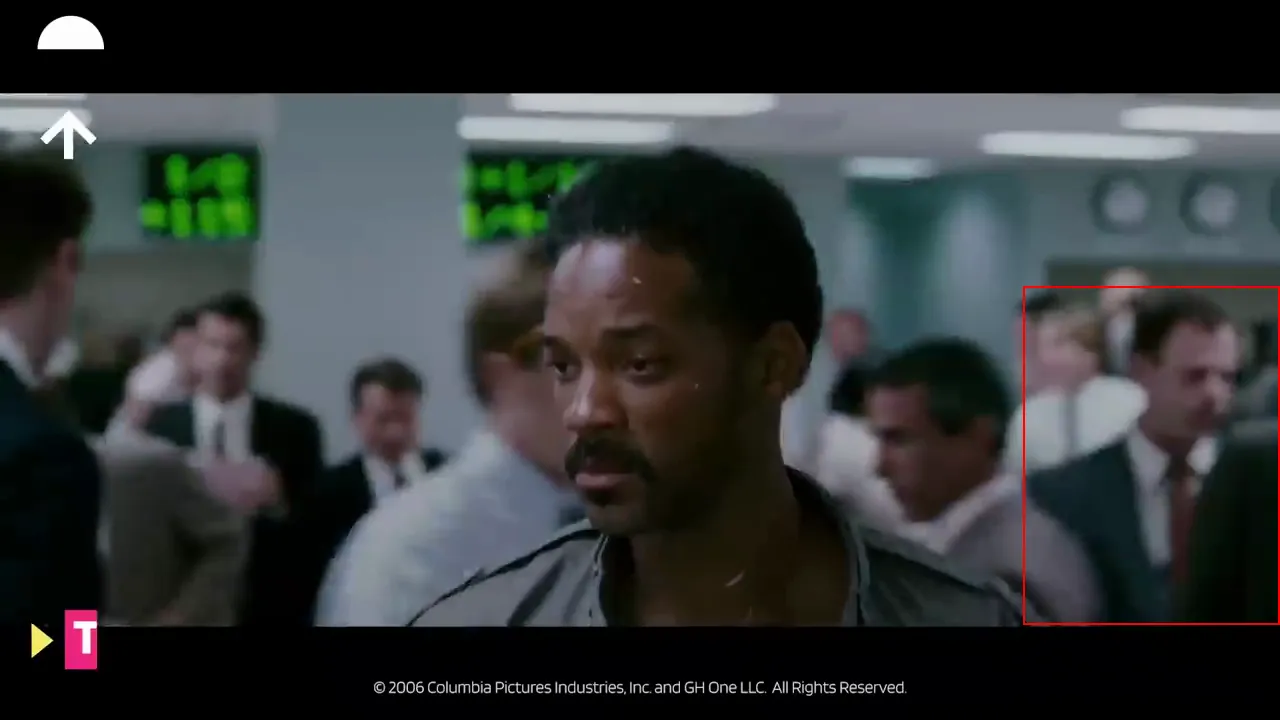
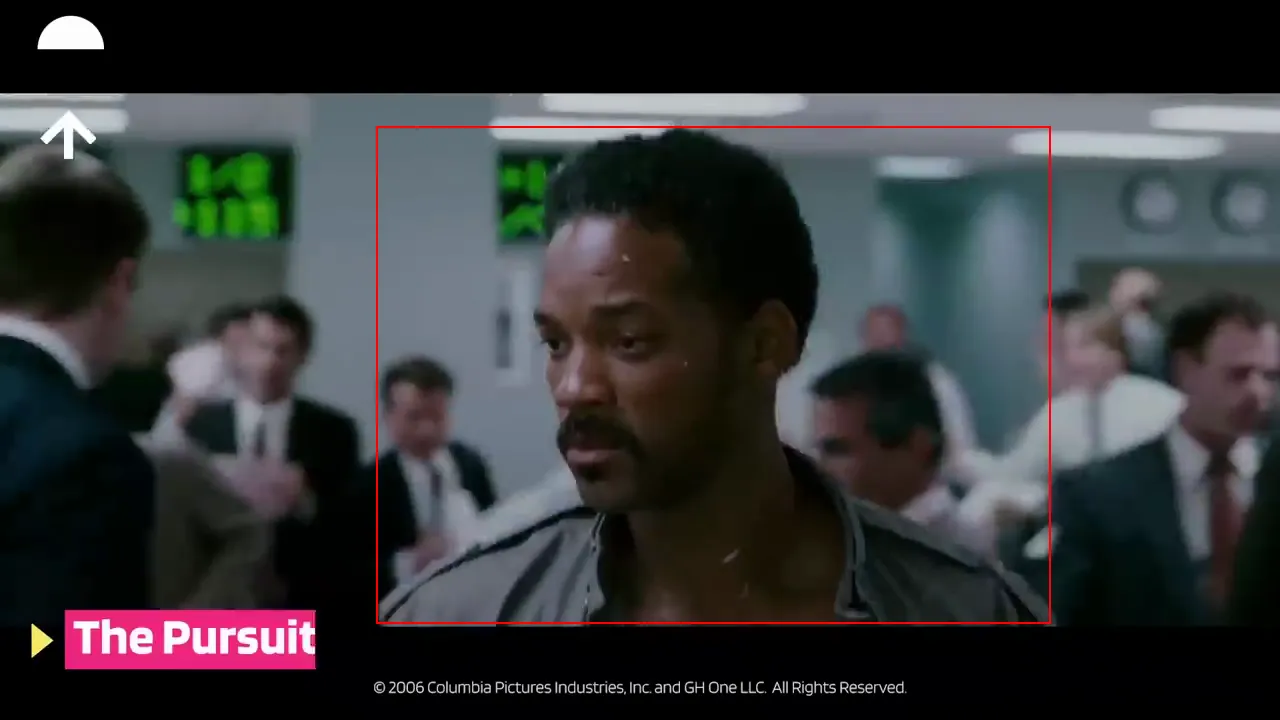
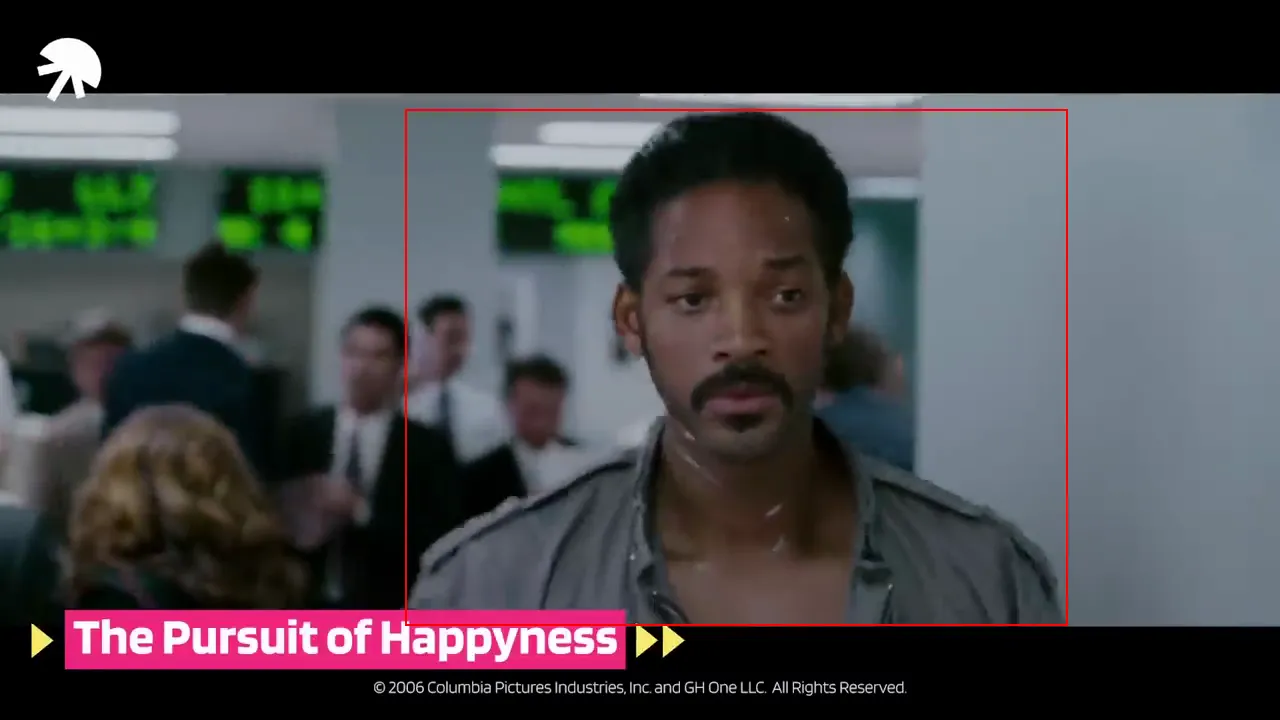

In [ ]:
# Preview a few frames with detected bboxes to see what smooth_reframe is tracking
frames.select(
    draw_bbox(frames.frame, frames.bbox, color='red', width=2),
    frames.bbox,
).limit(8).collect()

smooth_reframe
""

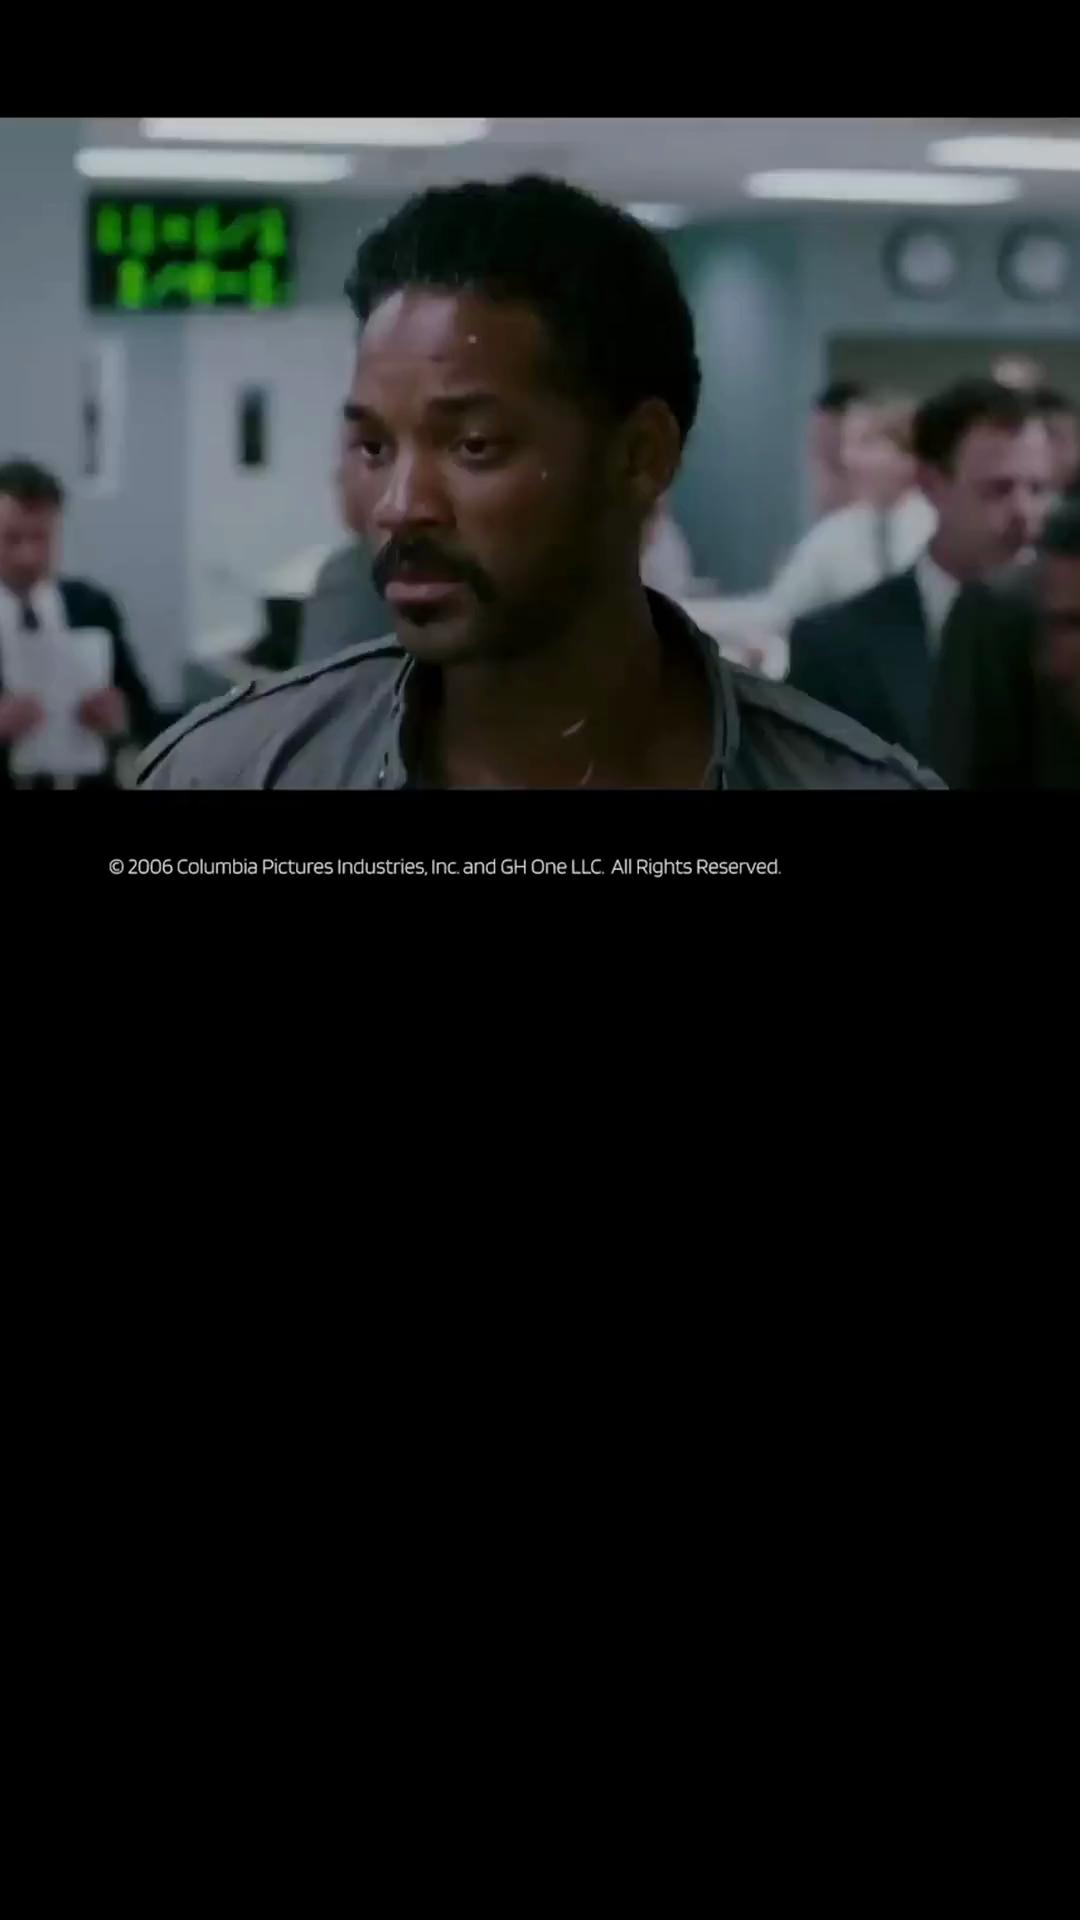

In [ ]:
# Assemble a 9:16 video that tracks the subject with smooth camera movement.
# smooth_reframe defaults to fps=15 — matching our frame_iterator extraction rate
# so the output plays at real-time speed.
result = (
    frames.select(smooth_reframe(frames.pos, frames.frame, frames.bbox))
    .group_by(tracking)
    .collect()
)
result

## Explanation

### Function reference

| Function | Ticket | Purpose | Key parameters |
|----------|--------|---------|----------------|
| `expand_bbox` | [PXT-968](https://pixeltable.atlassian.net/browse/PXT-968) | Add breathing room around a detection | `margin_factor=1.3` (scale), `padding=20` (pixels) |
| `fit_bbox_to_aspect` | [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) | Compute a crop region matching a target aspect ratio | `aspect_ratio='9:16'` |
| `rescale_bbox` | [PXT-967](https://pixeltable.atlassian.net/browse/PXT-967) | Adjust bbox after `resize()` | `from_size`, `to_size` |
| `offset_bbox` | [PXT-967](https://pixeltable.atlassian.net/browse/PXT-967) | Adjust bbox after `crop()` | `crop_box` — the region that was cropped |
| `video.crop()` | [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) | Static spatial crop of a video via ffmpeg | `box`, optional `target_size` |
| `smooth_reframe` | [PXT-966](https://pixeltable.atlassian.net/browse/PXT-966) | Tracking crop — follows subject across frames | `margin_factor`, `smoothing`, `max_zoom_rate` |

### Static crop vs. tracking crop

- **`video.crop()`**: One crop box for the entire video. Best when the subject is stationary or you already know the region.
- **`smooth_reframe()`**: Per-frame crop with exponential smoothing. Best when the subject moves and you want a smooth "camera follow" effect.

### How `fit_bbox_to_aspect` works

1. Centres on the bounding box
2. Expands the smaller dimension to match the target aspect ratio
3. Constrains to frame bounds (shifts if needed, never goes out of frame)
4. Returns a crop box in `(left, upper, right, lower)` format — ready for `image.crop()` or `video.crop()`

### How `smooth_reframe` works

1. For each frame: compute the raw centre and zoom from the detection bbox (expanded by `margin_factor`)
2. Apply exponential smoothing to both centre and zoom (`smoothing` controls responsiveness)
3. Clamp zoom change per frame to `max_zoom_rate` (e.g. 1.05 = max 5% zoom change per frame)
4. Crop and resize the frame to the target resolution
5. If no detection on a frame, hold the previous position (camera stays steady)

### All bounding boxes use PIL convention

Every function uses `(left, upper, right, lower)` — the same format as `PIL.Image.crop()` and Pixeltable's `image.crop()`. This means you can chain detection → expand → fit → crop without coordinate conversion.

## See also

- [Detect objects in images](https://docs.pixeltable.com/howto/cookbooks/images/img-detect-objects) — YOLOX object detection basics
- [Extract frames from videos](https://docs.pixeltable.com/howto/cookbooks/video/video-extract-frames) — Frame extraction for video analysis
- [PIL image transforms](https://docs.pixeltable.com/howto/cookbooks/images/img-pil-transforms) — Built-in image operations